---
<p><font  color=“9966FF”>***COMMENTS:***.<br>
<b><p> Overall: Average performance. <p>
<p>  
<p> The entire workflow need to be improved and some parts are not easy to follow. Data cleaning and EDA part need to be improved. Model training part need to be improved. Please find my detail comments below. </p></b></font></p> 

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# quick look at the data available
house.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1287,1288,20,RL,NaN,36500,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,190000
1424,1425,20,RL,NaN,9503,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,6,2007,WD,Normal,144000
442,443,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,162900
1188,1189,60,RL,68.0,8935,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,195000
551,552,20,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,112500


In [4]:
# check the columns availbale, the number of null objects
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# processing the missing data

In [6]:
# LotFrontage - fill up the missing data with the mean
null_indexes = house[house['LotFrontage'].isnull()].index
house.loc[null_indexes,'LotFrontage'] = np.mean(house['LotFrontage'])

# Alley - NaN - no alley access. repalce with "None" to prevent a Null Value
null_indexes = house[house['Alley'].isnull()].index
house.loc[null_indexes,'Alley'] = 'None'

# MasVnrType - replace NaN with None
null_indexes = house[house['MasVnrType'].isnull()].index
house.loc[null_indexes,'MasVnrType'] = 'None'

# MasVnrType - replace NaN with 0, assuming no veneer
null_indexes = house[house['MasVnrArea'].isnull()].index
house.loc[null_indexes,'MasVnrArea'] = 0

# BsmtQual - replace NaN with None, to prevent Null value
null_indexes = house[house['BsmtQual'].isnull()].index
house.loc[null_indexes,'BsmtQual'] = 'None'

# BsmtCond - replace NaN with None, to prevent Null value
null_indexes = house[house['BsmtCond'].isnull()].index
house.loc[null_indexes,'BsmtCond'] = 'None'

# BsmtQual - replace NaN with None, to prevent Null value
null_indexes = house[house['BsmtExposure'].isnull()].index
house.loc[null_indexes,'BsmtExposure'] = 'None'

# BsmtExposure - replace NaN with None, to prevent Null value
null_indexes = house[house['BsmtExposure'].isnull()].index
house.loc[null_indexes,'BsmtExposure'] = 'None'

# BsmtFinType1 - replace NaN with None, to prevent Null value
null_indexes = house[house['BsmtFinType1'].isnull()].index
house.loc[null_indexes,'BsmtFinType1'] = 'None'

# BsmtFinType2 - replace NaN with None, to prevent Null value
null_indexes = house[house['BsmtFinType2'].isnull()].index
house.loc[null_indexes,'BsmtFinType2'] = 'None'

# Electrical - replace NaN with the basic - SBrkr
null_indexes = house[house['Electrical'].isnull()].index
house.loc[null_indexes,'Electrical'] = 'SBrkr'

# FireplaceQu - NaN is when there is no fireplace. Replace with None
null_indexes = house[house['FireplaceQu'].isnull()].index
house.loc[null_indexes,'FireplaceQu'] = 'None'

# GarageType - NaN is when there is no Garage. Replace with None
null_indexes = house[house['GarageType'].isnull()].index
house.loc[null_indexes,'GarageType'] = 'None'

# GarageYrBlt - NaN is when there is no Garage. Replace with None
null_indexes = house[house['GarageYrBlt'].isnull()].index
house.loc[null_indexes,'GarageYrBlt'] = 'None'

# GarageFinish - NaN is when there is no Garage. Replace with None
null_indexes = house[house['GarageFinish'].isnull()].index
house.loc[null_indexes,'GarageFinish'] = 'None'

# GarageQual - NaN is when there is no Garage. Replace with None
null_indexes = house[house['GarageQual'].isnull()].index
house.loc[null_indexes,'GarageQual'] = 'None'

# GarageCond - NaN is when there is no Garage. Replace with None
null_indexes = house[house['GarageCond'].isnull()].index
house.loc[null_indexes,'GarageCond'] = 'None'

# PoolQC - NaN is when there is no Pool. Replace with None
null_indexes = house[house['PoolQC'].isnull()].index
house.loc[null_indexes,'PoolQC'] = 'None'

# Fence - NaN is when there is no Fence. Replace with None
null_indexes = house[house['Fence'].isnull()].index
house.loc[null_indexes,'Fence'] = 'None'

# MiscFeature - NaN is when there is no Special Features. Replace with None
null_indexes = house[house['MiscFeature'].isnull()].index
house.loc[null_indexes,'MiscFeature'] = 'None'

<font color='red'> You can do some data visuallisation and feature engineering. You can show the distribution of features and also can add bivariate analysis to understand the relationship between the target variable and predictors as well as the relationship among predictors. 

In [7]:
# rename variables of MSSubClass so that the numbers becomes a category instead of a value
house['MSSubClass'] = house['MSSubClass'].map(lambda x: 
                                             'A' if x == 20 else
                                             ('B' if x == 30 else
                                             ('C' if x == 40 else
                                             ('D' if x == 45 else
                                             ('E' if x == 50 else
                                             ('F' if x == 60 else
                                             ('G' if x == 70 else
                                             ('H' if x == 75 else
                                             ('I' if x == 80 else
                                             ('J' if x == 85 else
                                             ('K' if x == 90 else
                                             ('L' if x == 120 else
                                             ('M' if x == 150 else
                                             ('N' if x == 160 else
                                             ('O' if x == 180 else
                                             ('P' if x == 190 else 'Z')
                                             )))))))))))))))

In [8]:
# check for anymore null values
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null object
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 no

In [9]:
# since our focus is only residential data,
# the other data is dropped as it is not relevant

house = house[ (house['MSZoning']=='RH') |
               (house['MSZoning']=='RL') |
               (house['MSZoning']=='RP') |
               (house['MSZoning']=='RM') ]

In [10]:
house.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

In [11]:
# set up the various columns info

# fixed house features - quantity
cols_fixed_qty = ['LotArea','LotFrontage', '1stFlrSF', '2ndFlrSF', 
                  'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                  'BsmtHalfBath', 'FullBath', 'HalfBath', 
                  'BedroomAbvGr', 'KitchenAbvGr', 'GarageCars', 
                  'GarageArea', 'TotalBsmtSF', 'TotRmsAbvGrd']

# fixed house features - categories
cols_fixed_cat = ['MSSubClass', 'MSZoning',  'Street', 'Alley', 
                  'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 
                  'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'Foundation', 
                  'GarageType']

# renovate house features - quantity
cols_renovate_qty = ['MasVnrArea',  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                     'Fireplaces','WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 
                     'ScreenPorch', 'PoolArea', 'EnclosedPorch','OverallQual', 'OverallCond']

# renovate house features - category
cols_renovate_cat = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                     'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond','BsmtExposure', 
                     'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
                     'CentralAir', 'Electrical','KitchenQual', 'Functional',  
                     'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
                     'PavedDrive',  'PoolQC', 'Fence']
# other info
cols_info = ['Id', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
             'Utilities', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 
             'MiscFeature', 'MiscVal']
# target
cols_target = ['SalePrice']

<font color='red'> The fixed features are those cannot be changed and reno are the one you can change, right. However, you have chosen some of the fixed features as reno one. For example: features related to area cannot be changed (BsmtFinSF2: Type 2 finished square feet, BsmtUnfSF, PoolArea). only you can improve the quality and condition of house.  There are the list of changable features. 
    
    `changeable = ['OverallCond','RoofStyle','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive','Functional',
              'OverallQual','ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQual','YearRemodAdd']`

In [12]:
## Workflow to predict SalePrice based on Fixed Characteristics

# 1. get dummies for category columns

# 2. create a dataframe for fixed features only

# 3. split into test and training dataset (by Yrsold)

# 4. training dataset - StandardScale (fit_transform) qty cols
# and concat the dummies

# 5. test dataset - StandardScale (transform) qty cols
# and concat the dummies

# 6. train LR based on training dataset

# 7. get score based on testing dataset

# 8. reduce features to improve testing score

# 9. update master fixed dataset with new cols only

# 10. train LR based on training dataset

# 11. get score based on testing dataset

# 12. if score is satisfactory, 
#     proceed to estimate prices for all units

# 13. determine best estimates (unit with lowest error)

In [13]:
house.shape

(1385, 81)

In [14]:
# 1. get_dummies for category columns

dummies_fixed = pd.get_dummies(house[cols_fixed_cat])
dummies_fixed.sample(5)

,MSSubClass_A,MSSubClass_B,MSSubClass_C,MSSubClass_D,MSSubClass_E,MSSubClass_F,MSSubClass_G,MSSubClass_H,MSSubClass_I,MSSubClass_J,...,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
274,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
416,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1052,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
dummies_fixed.shape

(1385, 107)

In [16]:
# 2. create a dataframe for fixed features only

list_cols = cols_fixed_qty + cols_info + cols_target
df_fixed = pd.concat([house[list_cols], dummies_fixed], axis=1)
df_fixed.sample(5)

,LotArea,LotFrontage,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,...,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
1080,11040,80.0,1258,0,0,1258,0,1,2,0,...,0,0,0,0,1,0,0,0,0,0
96,10264,78.0,1588,0,0,1588,0,0,2,0,...,0,0,0,0,1,0,0,0,0,0
8,6120,51.0,1022,752,0,1774,0,0,2,0,...,0,0,0,0,0,0,0,0,1,0
867,6970,85.0,1120,0,0,1120,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1450,9000,60.0,896,896,0,1792,0,0,2,2,...,0,0,0,0,0,0,0,0,0,1


In [17]:
# 3. split into test and training dataset (by Yrsold)

df_fixed_train = df_fixed[df_fixed['YrSold']<2010]
df_fixed_test  = df_fixed[df_fixed['YrSold']==2010]

In [18]:
# 4. training dataset - StandardScale (fit_transform) qty cols

# scale the qty columns first
X_fixed_train = df_fixed_train[cols_fixed_qty]

from sklearn.preprocessing import StandardScaler
ss_fixed = StandardScaler()
Xs_fixed_train = pd.DataFrame(ss_fixed.fit_transform(X_fixed_train.astype(float)))
Xs_fixed_train.columns = cols_fixed_qty

# create the predictor matrix (include the dummies)
Xs_fixed_train = pd.concat([Xs_fixed_train.reset_index(drop=True), 
                            df_fixed_train[dummies_fixed.columns.values].reset_index(drop=True)], 
                            axis=1)

# create the target matrix
y_fixed_train = df_fixed_train[cols_target]

In [19]:
(Xs_fixed_train.shape, y_fixed_train.shape)

((1221, 123), (1221, 1))

In [20]:
# 5. test dataset - StandardScale (transform) qty cols

# scale the qty columns first
X_fixed_test = df_fixed_test[cols_fixed_qty]
# use transform only. assume test data is new data and not fitted
Xs_fixed_test = pd.DataFrame(ss_fixed.transform(X_fixed_test.astype(float)))
Xs_fixed_test.columns = cols_fixed_qty

# create the predictor matrix (include the dummies)
Xs_fixed_test = pd.concat([Xs_fixed_test.reset_index(drop=True), 
                            df_fixed_test[dummies_fixed.columns.values].reset_index(drop=True)], 
                            axis=1)

# create the target matrix
y_fixed_test = df_fixed_test[cols_target]

In [21]:
(Xs_fixed_test.shape, y_fixed_test.shape)

((164, 123), (164, 1))

In [22]:
# 6. train LR based on training dataset

from sklearn.linear_model import LinearRegression

lr_fixed = LinearRegression()
lr_fixed.fit(Xs_fixed_train, y_fixed_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

 <font color='red'> i have calculated the score for LinearRegression model. This part of baseline model you have done is wrong. YOu have fitted the model with the test data. Please check below for my calculation.

In [23]:
from sklearn.model_selection import cross_val_score
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs_fixed_train, y_fixed_train, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[ 8.65906776e-01  8.08116054e-01  8.43233055e-01 -9.23472313e+15
  7.48383193e-01 -8.19572234e+19 -2.07882981e+17  7.35843544e-01
 -3.04574258e+17  3.59571346e-01]
-8.247891537950599e+18


In [24]:
# 7. get score based on testing dataset
score_fixed = lr_fixed.score(Xs_fixed_test, y_fixed_test)
print('baseline score: {:6f}'.format(score_fixed))

baseline score: 0.843967


In [25]:
# 8. reduce features to improve testing score

In [26]:
# 8a. use RFECV only

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

R_selector = RFECV(LinearRegression(), step = 1, cv = 10)
R_selector.fit(Xs_fixed_train, y_fixed_train)
R_cols = np.array(Xs_fixed_train.columns)[R_selector.support_]
print('RFECV recommends to use only {} columns, which are: \n{}'.format(
      len(R_cols), R_cols))

# setup new predictor matrix based on RFECV recommendation
# and fit the data
Xs_fixed_train_R = Xs_fixed_train[R_cols]
lr_fixed_R = LinearRegression()
lr_fixed_R.fit(Xs_fixed_train_R, y_fixed_train)

# evaluate model score
Xs_fixed_test_R = Xs_fixed_test[R_cols]
score_fixed_R = lr_fixed_R.score(Xs_fixed_test_R, y_fixed_test)
print('-'*20)
print('RFECV score: {:6f}'.format(score_fixed_R))
print('-'*20)
print('since RFECV score ({:.4f}) is lower than baseline({:.4f}), RFECV recommendation should not be used'.format(score_fixed_R, score_fixed))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFECV recommends to use only 16 columns, which are: 
['MSSubClass_K' 'Alley_Grvl' 'Alley_None' 'Alley_Pave' 'LotShape_IR1'
 'LotShape_IR2' 'LotShape_IR3' 'LotShape_Reg' 'LandContour_Bnk'
 'LandContour_HLS' 'LandContour_Low' 'LandContour_Lvl' 'LandSlope_Gtl'
 'LandSlope_Mod' 'LandSlope_Sev' 'BldgType_Duplex']
--------------------
RFECV score: 0.163554
--------------------
since RFECV score (0.1636) is lower than baseline(0.8440), RFECV recommendation should not be used


In [27]:
# 8b. use LASSO only

In [28]:
from sklearn.linear_model import Lasso, LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0)
optimal_lasso.fit(Xs_fixed_train, y_fixed_train)
print('optimal alpha value is :', optimal_lasso.alpha_)

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(Xs_fixed_train, y_fixed_train)

lasso_coefs = pd.DataFrame({'variable':Xs_fixed_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print('Number of columns remaining:', len(lasso_coefs[lasso_coefs['coef'] != 0]), 'of', len(lasso_coefs))
print('Percent variables zeroed out:', len(lasso_coefs[lasso_coefs['coef'] == 0])/float(len(lasso_coefs)))
print('-'*20)
coefs = lasso_coefs[lasso_coefs['coef'] != 0]['variable']
L_cols = [col for col in coefs]

print('Columns to keep are: \n{}'.format(L_cols))

# create new predictor matrix based on Lasso recommendation
Xs_fixed_train_L = Xs_fixed_train[L_cols]
lr_fixed_L = LinearRegression()
lr_fixed_L.fit(Xs_fixed_train_L, y_fixed_train)

# evaluate model score
Xs_fixed_test_L = Xs_fixed_test[L_cols]
score_fixed_L = lr_fixed_L.score(Xs_fixed_test_L, y_fixed_test)
print('-'*20)
print('Lasso score: {:4f}'.format(score_fixed_L))
print('-'*20)
print('since Lasso score ({:.4f}) is lower than baseline({:.4f}),\
Lasso recommendation should not be used'.format(score_fixed_L, score_fixed))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


optimal alpha value is : 168.499456245168
Number of columns remaining: 61 of 123
Percent variables zeroed out: 0.5040650406504065
--------------------
Columns to keep are: 
['Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'Neighborhood_NoRidge', 'GrLivArea', 'Neighborhood_Somerst', 'Neighborhood_Edwards', 'MSSubClass_N', 'Neighborhood_Crawfor', 'GarageCars', 'Neighborhood_Veenker', 'LandContour_HLS', 'Condition2_PosN', 'LandContour_Bnk', 'MSSubClass_A', 'GarageType_None', 'Neighborhood_OldTown', 'Foundation_PConc', 'HouseStyle_2Story', 'MSSubClass_L', 'BedroomAbvGr', 'KitchenAbvGr', 'Neighborhood_NWAmes', 'LotShape_IR3', 'TotalBsmtSF', 'LotConfig_CulDSac', 'BsmtFullBath', 'BldgType_Twnhs', 'LotShape_IR2', 'Condition1_Norm', 'Neighborhood_Mitchel', 'TotRmsAbvGrd', 'FullBath', 'Neighborhood_NAmes', 'Neighborhood_Sawyer', 'Condition1_Feedr', 'HouseStyle_1.5Fin', 'Neighborhood_Gilbert', 'GarageType_2Types', 'HalfBath', 'GarageType_Detchd', 'LotArea', 'MSSubClass_I', 'BsmtHalfBath', '2ndFlr

<font color='red'> This part is difficukt to follow.  You can do it step by step with the output, instead of running all in one cell. I have print out the features down. 
    
    
 \n<font color='red'>
It is useful to also look at the scores for **each** fold in the cross validation scores to check for overfitting. 

In [29]:
lasso_coefs[:15]

,variable,coef,abs_coef
71,Neighborhood_NridgHt,65779.759779,65779.759779
77,Neighborhood_StoneBr,58119.891960,58119.891960
70,Neighborhood_NoRidge,51003.042883,51003.042883
5,GrLivArea,32446.867099,32446.867099
76,Neighborhood_Somerst,20544.309180,20544.309180
62,Neighborhood_Edwards,-17358.678615,17358.678615
28,MSSubClass_N,-15686.871670,15686.871670
61,Neighborhood_Crawfor,14357.658542,14357.658542
12,GarageCars,13255.139039,13255.139039
79,Neighborhood_Veenker,12706.257922,12706.257922


In [30]:
# 8c. use RFECV + LASSO 

R_selector = RFECV(LinearRegression(), step = 1, cv = 10)
R_selector.fit(Xs_fixed_train, y_fixed_train)
R_cols = np.array(Xs_fixed_train.columns)[R_selector.support_]

# based on RFECV's recommendation, create new predictor matrix
Xs_fixed_train_R = Xs_fixed_train[R_cols]

# feed the new predictor matrix into LassoCV
optimal_lasso_RL = LassoCV(n_alphas=500, cv=10, verbose=0)
optimal_lasso_RL.fit(Xs_fixed_train_R, y_fixed_train)
lasso_RL = Lasso(alpha=optimal_lasso_RL.alpha_)
lasso_RL.fit(Xs_fixed_train_R, y_fixed_train)

lasso_coefs_RL = pd.DataFrame({'variable':Xs_fixed_train_R.columns,
                            'coef':lasso_RL.coef_,
                            'abs_coef':np.abs(lasso_RL.coef_)})

lasso_coefs_RL.sort_values('abs_coef', inplace=True, ascending=False)

print('Number of columns remaining:', len(lasso_coefs_RL[lasso_coefs_RL['coef'] != 0]), 'of', len(lasso_coefs))
print('Percent variables zeroed out:', len(lasso_coefs_RL[lasso_coefs_RL['coef'] == 0])/float(len(lasso_coefs)))
print('-'*20)
coefs = lasso_coefs_RL[lasso_coefs_RL['coef'] != 0]['variable']
RL_cols = [col for col in coefs]

print('Columns to keep are: \n{}'.format(RL_cols))

# create new predictor matrix based on RFECV + Lasso recommendation
Xs_fixed_train_RL = Xs_fixed_train[RL_cols]
lr_fixed_RL = LinearRegression()
lr_fixed_RL.fit(Xs_fixed_train_RL, y_fixed_train)

# evaluate the score
Xs_fixed_test_RL = Xs_fixed_test[RL_cols]
score_fixed_RL = lr_fixed_RL.score(Xs_fixed_test_RL, y_fixed_test)
print('-'*20)
print('RFECV+Lasso score: {:4f}'.format(score_fixed_RL))
print('-'*20)
print('since RFECV+Lasso score ({:.4f}) is lower than baseline({:.4f}),\
RFECV+Lasso recommendation should not be used'.format(score_fixed_RL, score_fixed))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of columns remaining: 11 of 123
Percent variables zeroed out: 0.04065040650406504
--------------------
Columns to keep are: 
['Alley_Grvl', 'LotShape_Reg', 'MSSubClass_K', 'LandContour_Bnk', 'LotShape_IR2', 'LandContour_HLS', 'LandContour_Low', 'LandSlope_Mod', 'LandSlope_Sev', 'LandContour_Lvl', 'BldgType_Duplex']
--------------------
RFECV+Lasso score: 0.163598
--------------------
since RFECV+Lasso score (0.1636) is lower than baseline(0.8440),RFECV+Lasso recommendation should not be used


In [31]:
# After attempting to reduce the number of columns using:
# (1) RFECV, (2) LASSO, (3) RFECV+LASSO,
# the score has not improved. hence the full columns should be used

In [32]:
# 9. update master fixed dataset with new cols only

# step not required as new cols are the same as original columns
# master fixed dataset are stored in df_fixed

In [33]:
# 10. train LR based on training dataset

# step not required - LR model "lr_fixed" is still valid

In [34]:
# 11. get score based on testing dataset

# step not required - LR score "score_fixed" still valid

In [35]:
# scale the qty columns first
X_fixed_test = df_fixed_test[cols_fixed_qty]
# use transform only. assume test data is new data and not fitted
Xs_fixed_test = pd.DataFrame(ss_fixed.transform(X_fixed_test.astype(float)))
Xs_fixed_test.columns = cols_fixed_qty

# create the predictor matrix (include the dummies)
Xs_fixed_test = pd.concat( [Xs_fixed_test.reset_index(drop=True),
                             df_fixed_test[dummies_fixed.columns.values].reset_index(drop=True)],
                          axis = 1)

# create the target matrix
y_fixed_test = df_fixed_test[cols_target]

In [36]:
# 12. if score is satisfactory, 
#     proceed to estimate prices for all units

# Scale the predictor matrix
X_fixed = df_fixed[cols_fixed_qty]
Xs_fixed = pd.DataFrame(ss_fixed.transform(X_fixed.astype(float)))
Xs_fixed.columns = cols_fixed_qty
# add in the dummies
Xs_fixed = pd.concat( [Xs_fixed.reset_index(drop=True),
                       df_fixed[dummies_fixed.columns.values].reset_index(drop=True)],
                      axis = 1)

# predict the prices
df_fixed['Pred_Price_Fixed'] = lr_fixed.predict(Xs_fixed)

In [37]:
# 13. determine best estimates (unit with lowest error)

df_fixed['Error_Fixed'] = df_fixed['Pred_Price_Fixed'] - df_fixed['SalePrice']
df_fixed['Error_Fixed_abs'] = np.abs(df_fixed['Error_Fixed'])

In [38]:
fixed_results = df_fixed.sort_values(by='Error_Fixed_abs', ascending=True)
fixed_results.reset_index(drop=True, inplace=True)
fixed_results.head(10)

,LotArea,LotFrontage,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,...,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Pred_Price_Fixed,Error_Fixed,Error_Fixed_abs
0,6240,52.000000,1042,534,0,1576,0,0,1,0,...,0,0,0,0,0,1,0,148991.0,-9.0,9.0
1,12640,55.000000,1728,0,0,1728,0,0,2,0,...,0,1,0,0,0,0,0,150918.0,18.0,18.0
2,6000,60.000000,936,0,0,936,0,0,1,0,...,0,0,0,0,0,1,0,93019.0,19.0,19.0
3,9187,71.000000,1080,0,0,1080,0,0,1,1,...,0,1,0,0,0,0,0,134028.0,28.0,28.0
4,18890,70.049958,1361,1259,0,2620,0,0,2,2,...,0,0,0,1,0,0,0,189951.0,-49.0,49.0
5,7892,55.000000,918,0,0,918,0,0,2,0,...,0,1,0,0,0,0,0,99448.0,-52.0,52.0
6,9317,75.000000,1006,769,0,1775,1,0,2,1,...,0,1,0,0,0,0,0,213062.0,62.0,62.0
7,11500,70.049958,1680,0,0,1680,0,0,2,0,...,0,0,0,0,0,1,0,136971.0,66.0,66.0
8,9291,76.000000,832,878,0,1710,0,0,2,1,...,0,1,0,0,0,0,0,186933.0,-67.0,67.0
9,9000,50.000000,1089,661,0,1750,0,0,1,0,...,0,0,0,0,0,1,0,123927.0,-73.0,73.0


In [39]:
fixed_results['Error_Fixed_abs'].describe()

count      1385.000000
mean      20830.158123
std       24415.289320
min           9.000000
25%        6184.000000
50%       14265.000000
75%       27445.000000
max      321823.000000
Name: Error_Fixed_abs, dtype: float64

In [40]:
HL = ['higher' if fixed_results['Error_Fixed'][0]> 0 else 'lower']

print('The best estimated house price is for house Id {} with an estimated price of ${:.2f}K.\
 The estimated price is ${:.2f} {} than the actual sale price of ${:.2f}K'.format(
       fixed_results['Id'].values[0], fixed_results['Pred_Price_Fixed'].values[0]/1000.,
       fixed_results['Error_Fixed_abs'].values[0], HL[0], fixed_results['SalePrice'].values[0]/1000.))

The best estimated house price is for house Id 1146 with an estimated price of $148.99K. The estimated price is $9.00 lower than the actual sale price of $149.00K


<font color='red'> The answer for this part of the question is not satisfactory. Thorough data visualisation and the feature engineering is required. Model training and testing has to be improved. Explanation and write up is missing. Would've been nice to see a little more EDA - exploring multicollinearity between independent variables, distribution of other independent variables etc. MOdel evaluation part is missing, you can do some residual analysis and calculate RMSE to validate the model.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [41]:
## Workflow to predict effect of renovate-able Characteristics

# 1. get dummies for category columns

# 2. create a dataframe for renovate features only

# 3. split into test and training dataset (by Yrsold)

# 4. training dataset - StandardScale (fit_transform) qty cols

# 5. test dataset - StandardScale (transform) qty cols

# 6. train LR based on training dataset

# 7. get score based on testing dataset

# 8. estimate prices for renovate-able features

# 9. estimate prices for house prices (fixed + renovate)

# 10. analysis of "whether they should buy a property or not"
# sort data by "renovate-able" features, descending order
# to buy the property and renovate if the renovate-able features increases the sale prices

# 11. analysis of "investigate how much variance in price remaining is explained by these features"

# 12. do you trust your model? shoudl it be used to evaluate which properties to buy and fix up?

In [42]:
# 1. get dummies for category columns

dummies_renovate = pd.get_dummies(house[cols_renovate_cat])
dummies_renovate.sample(5)

,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,...,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None
976,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
631,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
521,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
1167,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
592,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1


In [43]:
dummies_renovate.shape

(1385, 150)

In [44]:
# 2. create a dataframe for renovate-able features only

list_cols = cols_renovate_qty + cols_info + cols_target
df_fixed_cols = ['Pred_Price_Fixed', 'Error_Fixed', 'Error_Fixed_abs']
df_renovate = pd.concat( [house[list_cols], dummies_renovate], axis = 1)
df_renovate = pd.concat( [df_renovate, df_fixed[df_fixed_cols]], axis = 1)
df_renovate.sample(5)

,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,...,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,Pred_Price_Fixed,Error_Fixed,Error_Fixed_abs
509,132.0,991,0,50,0,224,88,0,0,0,...,0,1,0,0,1,0,0,130030.0,5530.0,5530.0
118,0.0,1470,0,203,2,367,0,0,0,0,...,0,1,0,0,0,0,1,341288.0,21288.0,21288.0
474,0.0,1196,0,298,0,96,48,0,0,0,...,0,1,0,0,0,0,1,269029.0,18029.0,18029.0
1273,84.0,719,0,300,1,0,0,0,163,0,...,0,1,1,0,0,0,0,138781.0,-38219.0,38219.0
336,200.0,1249,0,673,1,178,51,0,0,0,...,0,1,0,0,0,0,1,359743.0,-17683.0,17683.0


In [45]:
len(list_cols)

25

In [46]:
df_renovate.shape

(1385, 178)

In [47]:
# 3. split into test and training dataset (by Yrsold)

df_renovate_train = df_renovate[df_renovate['YrSold']<2010]
df_renovate_test  = df_renovate[df_renovate['YrSold']==2010]

In [48]:
(df_renovate_train.shape, df_renovate_test.shape)

((1221, 178), (164, 178))

In [49]:
# 4. training dataset - StandardScale (fit_transform) qty cols

# Scale the quantity columns for renovate
X_renovate_train = df_renovate_train[cols_renovate_qty]
ss_renovate = StandardScaler()
Xs_renovate_train = pd.DataFrame(ss_renovate.fit_transform(X_renovate_train.astype(float)))
Xs_renovate_train.columns = cols_renovate_qty
# create predictor matrix for renovate by adding back the category dummies
Xs_renovate_train = pd.concat( [Xs_renovate_train.reset_index(drop=True),
                                   df_renovate_train[dummies_renovate.columns.values].reset_index(drop=True)],
                                  axis = 1)
# create target matrix
y_renovate_train = df_renovate_train['Error_Fixed']

In [50]:
(Xs_renovate_train.shape, y_renovate_train.shape)

((1221, 163), (1221,))

In [51]:
# 5. test dataset - StandardScale (transform) qty cols

# Scale the qty columns for renovate
X_renovate_test = df_renovate_test[cols_renovate_qty]
Xs_renovate_test = pd.DataFrame(ss_renovate.transform(X_renovate_test.astype(float)))
Xs_renovate_test.columns = cols_renovate_qty

# create predictor matrix for renovate by adding back the category dummies
Xs_renovate_test = pd.concat( [Xs_renovate_test.reset_index(drop=True),
                               df_renovate_test[dummies_renovate.columns.values].reset_index(drop=True)],
                              axis = 1)

# create target matrix
y_renovate_test = df_renovate_test['Error_Fixed']

In [52]:
(Xs_renovate_test.shape, y_renovate_test.shape)

((164, 163), (164,))

In [53]:
# 6. train LR based on training dataset

lr_renovate = LinearRegression()
lr_renovate.fit(Xs_renovate_train, y_renovate_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [54]:
# 7. get score based on testing dataset

lr_renovate.score(Xs_renovate_test, y_renovate_test)

-1069626966738192.8

In [55]:
# 8. estimate prices for renovate-able features

df_renovate['Pred_Price_Reno'] = lr_renovate.predict(df_renovate[Xs_renovate_train.columns.values])

In [56]:
# 9. estimate prices for house prices (fixed + renovate)

df_renovate['Pred_Price_Fixed_Reno'] = df_renovate['Pred_Price_Fixed'] + df_renovate['Pred_Price_Reno']
df_renovate['Error_Fixed_Reno'] = df_renovate['Pred_Price_Fixed_Reno'] - df_renovate['SalePrice']
df_renovate['Error_Fixed_Reno_abs'] = np.abs(df_renovate['Error_Fixed_Reno'])

In [57]:
results_reno = df_renovate.sort_values(by='Error_Fixed_Reno_abs', ascending = True).reset_index(drop=True)
results_reno.head(10)

,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,...,Fence_MnPrv,Fence_MnWw,Fence_None,Pred_Price_Fixed,Error_Fixed,Error_Fixed_abs,Pred_Price_Reno,Pred_Price_Fixed_Reno,Error_Fixed_Reno,Error_Fixed_Reno_abs
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,95117.0,13117.0,13117.0,-20022.2500,75094.7500,-6905.2500,6905.2500
1,0.0,0,0,0,1,0,59,0,0,0,...,0,0,1,120345.0,-14087.0,14087.0,7123.4375,127468.4375,-6963.5625,6963.5625
2,0.0,0,0,0,0,0,27,0,0,0,...,0,0,1,116721.0,18421.0,18421.0,-34651.2500,82069.7500,-16230.2500,16230.2500
3,0.0,0,0,0,0,0,96,0,0,0,...,1,0,0,108793.0,793.0,793.0,15629.5000,124422.5000,16422.5000,16422.5000
4,0.0,0,0,0,0,220,114,0,0,0,...,0,0,1,56057.0,-50193.0,50193.0,31012.4375,87069.4375,-19180.5625,19180.5625
5,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,68345.0,29045.0,29045.0,-49385.3125,18959.6875,-20340.3125,20340.3125
6,0.0,104,712,0,0,106,0,0,0,0,...,0,0,1,107090.0,-2910.0,2910.0,-20419.2500,86670.7500,-23329.2500,23329.2500
7,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,60946.0,5946.0,5946.0,-34047.8125,26898.1875,-28101.8125,28101.8125
8,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,94393.0,893.0,893.0,-30565.5000,63827.5000,-29672.5000,29672.5000
9,75.0,0,0,0,1,0,0,0,0,0,...,0,0,0,166336.0,51336.0,51336.0,-84571.1875,81764.8125,-33235.1875,33235.1875


In [58]:
print('The best estimated price is for renovation features is house Id {}.\
The estimation of renovation features reduces the estimation error in house price by ${:.2f} \
from ${:.2f} to ${:.2f}'.format(results_reno['Id'].values[0], results_reno['Error_Fixed_Reno_abs'].values[0],
                             results_reno['Error_Fixed_abs'].values[0], results_reno['Error_Fixed_Reno_abs'].values[0]))


The best estimated price is for renovation features is house Id 1001.The estimation of renovation features reduces the estimation error in house price by $6905.25 from $13117.00 to $6905.25


In [59]:
analysis_1 = df_renovate[['Id','SalePrice', 'Pred_Price_Fixed','Error_Fixed','Error_Fixed_abs','Pred_Price_Reno',
                          'Pred_Price_Fixed_Reno', 'Error_Fixed_Reno','Error_Fixed_Reno_abs']]
analysis_1.sample(5)

,Id,SalePrice,Pred_Price_Fixed,Error_Fixed,Error_Fixed_abs,Pred_Price_Reno,Pred_Price_Fixed_Reno,Error_Fixed_Reno,Error_Fixed_Reno_abs
1077,1078,138800,139018.0,218.0,218.0,642128.75,781146.75,642346.75,642346.75
280,281,228500,204330.0,-24170.0,24170.0,1186025.50,1390355.50,1161855.50,1161855.50
374,375,219500,211571.0,-7929.0,7929.0,2376900.50,2588471.50,2368971.50,2368971.50
1121,1122,212900,223765.0,10865.0,10865.0,4169121.75,4392886.75,4179986.75,4179986.75
123,124,153900,146768.0,-7132.0,7132.0,2896015.75,3042783.75,2888883.75,2888883.75


In [60]:
# 10. analysis of "whether they should buy a property or not"


# assuming the second model (price estimation of renovation features) is accurate,
# the company should purchase houses with: 
# (1) a negative "Error_Fixed" which means value of land/house is under-valued, and
# (2) a positive "Pred_Price_Reno" which means the renovation value-added the price of the house

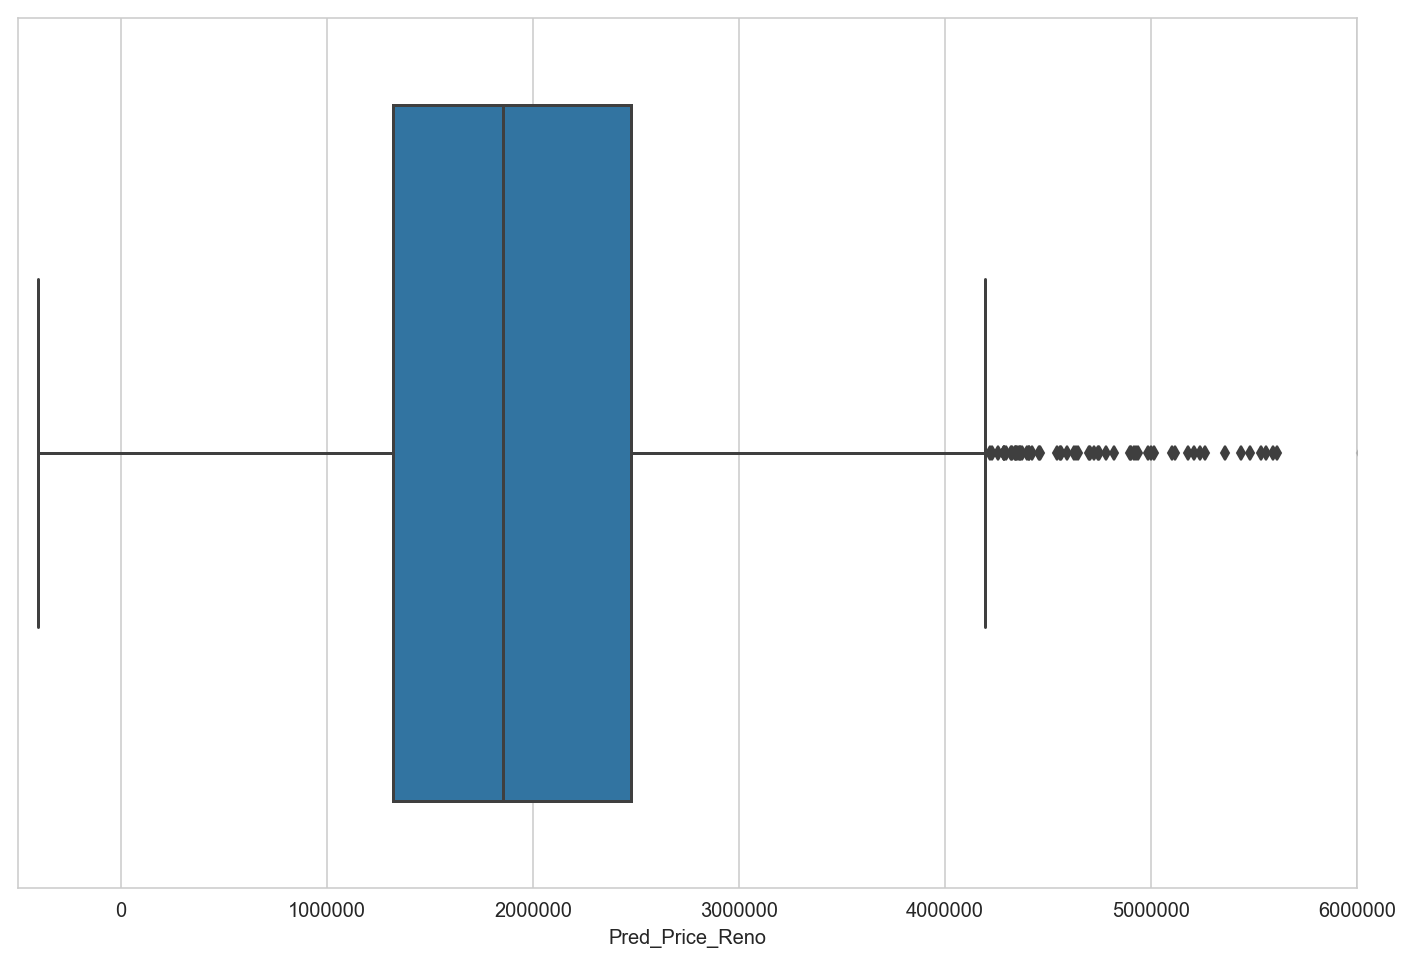

In [61]:
# 11. analysis of "investigate how much variance in price remaining is explained by these features"

fig , ax = plt.subplots(figsize=(12,8))
sns.boxplot(analysis_1['Pred_Price_Reno'], orient='h')
plt.xlim(-500000,6000000)
plt.show()

In [62]:
# 12. do you trust your model? should it be used to evaluate which properties to buy and fix up?


# no. the r2_score of the renovation model is negative. 
# it would be better to estimate based on the fixed characteristics of the house

<font color='red'> The answer for this part of question is not satisfactory. As discussed in the  previous question, the features you have chosen for reno features are not correct. And you need to improve on model training and testing. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [63]:
# A: